In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid

from pyproj import Geod


from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Input data
kitchen = pd.read_csv("input/kitchen.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")
customer = pd.read_csv("input/customer.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")

customer1 = pd.read_csv("input/customer.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")
kitchen1 = pd.read_csv("input/kitchen.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")


# Overview
Kunci utama dari Efisiensi pengiriman menurut kami adalah customer harus terassign ke kitchen yang paling optimum dulu. Dimana kitchen optimum tidak selalu kitchen yang paling dekat dengan customer. Solusi optimum = Sort dari Outermost customer dan ada mekanisme penukaran apabila kitchen sudah full.

Karena susah, kami melakukan sedikit perubahan

-menSort customer dari jarak yang paling jauh dari titik pusat customer (sum/total lat long).

-assign customer ke kitchen terdekat

-apabila kitchen terdekat sudah full maka diassign ke kitchen kedua terdekat, dst.

Sehingga bisa didapat group berupa customer yang terassign ke suatu kitchen.
Solusi tersebut belum optimal,tapi cukup mendekati.

Kurir kemudian di assign per group berdasarkan degree dan jarak. Kami berusaha mengoptimalkan waktu pengiriman selama satu jam (Sebisa mungkin kurir mendapat jarak yang sama, Tidak ada kurir yang terlalu cepat selesai atau terlalu lama selesai). Di assign tidak hanya berdasarkan jarak untuk mengoptimalkan waktu pengiriman selama 1 jam.

In [3]:
import bokeh.plotting as bk
from bokeh.plotting import figure, show, output_file

bk.output_notebook()


def mscatter(p, x, y, marker, color):
    p.scatter(x, y, marker=marker, size=10,line_color="black", fill_color=color, alpha=1)
def mtext(p, x, y, text):
    p.text(x, y, text=text, text_color="black", text_align="center", text_font_size="10pt")    

p = figure(title="Persebaran Customer dan Kitchen",match_aspect=True, aspect_scale=1,plot_width=900)
p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
#p.axis.visible = False

mscatter(p, customer['long'], customer['lat'], "circle", "red")
mscatter(p, kitchen['long'], kitchen['lat'], "square", "blue")
mtext(p, kitchen['long'], kitchen['lat'],["Dapur Miji","Dapur Nusantara","Familia Catering","Pondok Catering","Rose Catering","Tiga Kitchen Catering","Ummu Uwais"])


show(p)

Loading BokehJS ...

# Why

Kalau ada algoritmanya kenapa tidak.

Yang lain sudah pada pake algen/greedy, anti mainstream.

Cepat. Running menentukan kurir hanya butuh kedipan mata (codingan ini belum di optimasisasi & sudah include visualisasi)

Tiap ada customer baru, assignment kurir langsung jadi.

# Grouping customer to the best kitchen

In [4]:
# Find center point of customer, buat nyari
# long
long_centroid = sum(customer['long'])/len(customer)
# lat
lat_centroid = sum(customer['lat'])/len(customer)

### Find Center Point of Customer

In [5]:
p = figure(title="Persebaran Customer dan Titik Pusat Customer", match_aspect=True,aspect_scale=1, plot_width=900)
p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
#p.axis.visible = False

mscatter(p, customer['long'], customer['lat'], "circle", "red")
mscatter(p, long_centroid, lat_centroid, "square", "blue")
mtext(p, long_centroid, lat_centroid, ["Titik Pusat Customer"])


show(p)

### Calculate distance to each kitchen

In [6]:

from math import *
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    km = 6367 * c
    return km

"""
customer1['dist0'] = ""
for i in customer1.index:
    customer1['dist0'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[0],kitchen['lat'].iloc[0])
customer1['dist1'] = ""
for i in customer1.index:
    customer1['dist1'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[1],kitchen['lat'].iloc[1])
customer1['dist2'] = ""
for i in customer1.index:
    customer1['dist2'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[2],kitchen['lat'].iloc[2])
customer1['dist3'] = ""
for i in customer1.index:
    customer1['dist3'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[3],kitchen['lat'].iloc[3])
customer1['dist4'] = ""    
for i in customer1.index:
    customer1['dist4'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[4],kitchen['lat'].iloc[4])
customer1['dist5'] = ""    
for i in customer1.index:
    customer1['dist5'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[5],kitchen['lat'].iloc[5])
customer1['dist6'] = ""
for i in customer1.index:
    customer1['dist6'].loc[i] = haversine(customer1['long'].loc[i],customer1['lat'].loc[i],kitchen['long'].iloc[6],kitchen['lat'].iloc[6])
"""    
# approximate distance in meter = euclidean distance * 111km
# not so accurate, but fast
customer1['dist0'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[0]])**2 + (customer.lat-[kitchen['lat'].iloc[0]]*len(customer))**2)
customer1['dist1'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[1]])**2 + (customer.lat-[kitchen['lat'].iloc[1]]*len(customer))**2)
customer1['dist2'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[2]])**2 + (customer.lat-[kitchen['lat'].iloc[2]]*len(customer))**2)
customer1['dist3'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[3]])**2 + (customer.lat-[kitchen['lat'].iloc[3]]*len(customer))**2)
customer1['dist4'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[4]])**2 + (customer.lat-[kitchen['lat'].iloc[4]]*len(customer))**2)
customer1['dist5'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[5]])**2 + (customer.lat-[kitchen['lat'].iloc[5]]*len(customer))**2)
customer1['dist6'] = 111*np.sqrt( (customer.long-[kitchen['long'].iloc[6]])**2 + (customer.lat-[kitchen['lat'].iloc[6]]*len(customer))**2)

In [7]:
a = pd.DataFrame(np.sort(customer1[['dist0','dist1','dist2','dist3','dist4','dist5','dist6']].values)[:,:6], columns=['nearest','2nearest', '3nearest','4nearest','5nearest','6nearest'])
#a = pd.DataFrame(np.sort(customer1[['dist0','dist1','dist2','dist3','dist4','dist5']].values)[:,:5], columns=['nearest','2nearest', '3nearest','4nearest','5nearest'])

customer1 = customer1.join(a)
customer1.head()

,customersName,long,lat,qtyOrdered,dist0,dist1,dist2,dist3,dist4,dist5,dist6,nearest,2nearest,3nearest,4nearest,5nearest,6nearest
0,53WJWGRK,106.836794,-6.217340,5,7.790967,6.902178,5.487746,1.336934,8.041811,3.864527,9.651074,1.336934,3.864527,5.487746,6.902178,7.790967,8.041811
1,34JD8T7P,106.824099,-6.183299,9,3.763673,10.742544,3.525696,4.538336,4.236888,2.568727,12.915884,2.568727,3.525696,3.763673,4.236888,4.538336,10.742544
2,1FD97O63,106.820074,-6.203792,5,5.920023,8.559258,3.155127,2.374799,5.794761,3.721517,11.998288,2.374799,3.155127,3.721517,5.794761,5.920023,8.559258
3,39R7P6D7,106.912387,-6.205225,1,12.420677,11.923608,13.231817,9.725849,13.964787,7.602669,5.740741,5.740741,7.602669,9.725849,11.923608,12.420677,13.231817
4,4E74CSUP,106.708647,-6.169678,3,11.953054,18.562583,9.799263,14.441354,9.789578,15.465617,24.787460,9.789578,9.799263,11.953054,14.441354,15.465617,18.562583


In [8]:
print(kitchen1)

             kitchenName        long       lat  minCapacity  maxCapacity  \
0             Dapur Miji  106.814653 -6.150735           50          100   
1        Dapur Nusantara  106.834772 -6.279489           30           40   
2       Familia Catering  106.793820 -6.192896           50           60   
3           Pondok Rawon  106.826822 -6.224094           50           70   
4          Rose Catering  106.795993 -6.157473           70           80   
5  Tiga Kitchen Catering  106.847226 -6.184124           30           50   
6             Ummu Uwais  106.914214 -6.256911           20           50   

   tolerance  
0        105  
1         45  
2         65  
3         75  
4         85  
5         55  
6         55  


### Sort by longest distance to Center Point of Customer

In [9]:
# Find distance from customer point to central customer point
#customer1['distSort'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[lat_centroid]*len(customer),[lat_centroid]*len(customer))
customer1['distSort'] = 111*np.sqrt( (customer.long-long_centroid)**2 + (customer.lat-lat_centroid)**2)

# Sort by longest distance
customer1 = customer1.sort_values(['distSort'], ascending=False)

In [10]:
customer1.reset_index(drop=True, inplace=True)
df1 = customer1.head(round(len(customer)*10/10))
df2 = customer1.tail(round(len(customer)*0/10))
customer1.drop(customer1.head(round(len(customer)*10/10)).index, inplace=True)
customer1.drop(customer1.tail(round(len(customer)*0/10)).index, inplace=True)

df2 = df2.append(df1,ignore_index=True)
df2 = df2.append(customer1,ignore_index=True)
customer1 = df2

### Assign Customer to Nearest Kitchen

In [11]:
# Data already sorted from (almost) outermost customer 
# For each row in the column,assign customer to the the nearest kitchen, 
# if the kitchen already full, assign customer to the second nearest kitchen and so on.
# IF MAGIC
clusters = []
dis2clusters = []
#masih manual
cap0 = 0
cap1 = 0
cap2 = 0
cap3 = 0
cap4 = 0
cap5 = 0
cap6 = 0
dis2cluster = 0


for i in customer1.index:

# Nearest    
    if (customer1['nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]


# 2nd Nearest
    elif (customer1['2nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['2nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]

# 3rd Nearest
    elif (customer1['3nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['3nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]

# 4th Nearest
    elif (customer1['4nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['4nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]

# 5th Nearest
    elif (customer1['5nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['5nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]
        
# 6th Nearest
    elif (customer1['6nearest'].loc[i]==customer1['dist0'].loc[i]) and (cap0<100):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist1'].loc[i] and (cap1<40):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist2'].loc[i] and (cap2<60):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist3'].loc[i] and (cap3<70):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist4'].loc[i] and (cap4<80):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist5'].loc[i] and (cap5<50):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif customer1['6nearest'].loc[i]==customer1['dist6'].loc[i] and (cap6<50):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]
# sisa
    elif (cap0+customer1['qtyOrdered'].loc[i]<105):
        cluster=0
        cap0=cap0+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist0'].loc[i]
    elif (cap1+customer1['qtyOrdered'].loc[i]<45):
        cluster=1
        cap1=cap1+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist1'].loc[i]
    elif (cap2+customer1['qtyOrdered'].loc[i]<65):
        cluster=2
        cap2=cap2+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist2'].loc[i]
    elif (cap3+customer1['qtyOrdered'].loc[i]<75):
        cluster=3
        cap3=cap3+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist3'].loc[i]
    elif (cap4+customer1['qtyOrdered'].loc[i]<85):
        cluster=4
        cap4=cap4+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist4'].loc[i]
    elif (cap5+customer1['qtyOrdered'].loc[i]<55):
        cluster=5
        cap5=cap5+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist5'].loc[i]
    elif (cap6+customer1['qtyOrdered'].loc[i]<55):
        cluster=6
        cap6=cap6+customer1['qtyOrdered'].loc[i]
        dis2cluster = customer1['dist6'].loc[i]

    
    clusters.append(cluster)       
    dis2clusters.append(dis2cluster)    
    
customer1['cluster'] = clusters
customer1['distance2cluster'] = dis2clusters

### Grouped Customer

In [12]:
p = figure(title="Persebaran Customer dan Kitchen",match_aspect=True, aspect_scale=1,plot_width=900)
p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
#p.axis.visible = False

mscatter(p, customer1['long'].loc[customer1['cluster'] == 0], customer1['lat'].loc[customer1['cluster'] == 0], "circle", "#1f77b4") # blue dark
mscatter(p, customer1['long'].loc[customer1['cluster'] == 1], customer1['lat'].loc[customer1['cluster'] == 1], "circle", "#aec7e8") # blue light
mscatter(p, customer1['long'].loc[customer1['cluster'] == 2], customer1['lat'].loc[customer1['cluster'] == 2], "circle", "#ff7f0e") # orange dark
mscatter(p, customer1['long'].loc[customer1['cluster'] == 3], customer1['lat'].loc[customer1['cluster'] == 3], "circle", "#ffbb78") # orange light
mscatter(p, customer1['long'].loc[customer1['cluster'] == 4], customer1['lat'].loc[customer1['cluster'] == 4], "circle", "#2ca02c") # green dark
mscatter(p, customer1['long'].loc[customer1['cluster'] == 5], customer1['lat'].loc[customer1['cluster'] == 5], "circle", "#98df8a") # green light
mscatter(p, customer1['long'].loc[customer1['cluster'] == 6], customer1['lat'].loc[customer1['cluster'] == 6], "circle", "#d62728") # red

#mscatter(p, customer1['long'], customer1['lat'], "circle", "red")
mscatter(p, kitchen['long'], kitchen['lat'], "square", "white")
mtext(p, kitchen['long'], kitchen['lat'],["Dapur Miji","Dapur Nusantara","Familia Catering","Pondok Catering","Rose Catering","Tiga Kitchen Catering","Ummu Uwais"])

show(p)

In [13]:
# Count customer order assigned to Kitchen
dapurMiji = (customer1.where(customer1['cluster'] == 0))['qtyOrdered'].sum()
dapurNusantara = (customer1.where(customer1['cluster'] == 1))['qtyOrdered'].sum()
familiaCatering = (customer1.where(customer1['cluster'] == 2))['qtyOrdered'].sum()
pondokRawon = (customer1.where(customer1['cluster'] == 3))['qtyOrdered'].sum()
roseCatering = (customer1.where(customer1['cluster'] == 4))['qtyOrdered'].sum()
tigaKitchenCatering = (customer1.where(customer1['cluster'] == 5))['qtyOrdered'].sum()
ummuUwais = (customer1.where(customer1['cluster'] == 6))['qtyOrdered'].sum()

d = {'Dapur Miji': dapurMiji , 'Dapur Nusantara': dapurNusantara, 'Familia Catering': familiaCatering, 'Pondok Rawon': pondokRawon,'Rose Catering': roseCatering, 'Tiga Kitchen Catering': tigaKitchenCatering, 'Ummu Uwais': ummuUwais}

In [14]:
# Print sum of assigned
# Cek apakah memenuhi constraint
print(d,"\n")
print("Cek apakah jumlah order sesuai :")
print(customer1['qtyOrdered'].sum()," pada data input")
print(cap0+cap1+cap2+cap3+cap4+cap5+cap6," pada hasil assign")

{'Dapur Miji': 103.0, 'Dapur Nusantara': 45.0, 'Familia Catering': 60.0, 'Pondok Rawon': 70.0, 'Rose Catering': 82.0, 'Tiga Kitchen Catering': 50.0, 'Ummu Uwais': 26.0} 

Cek apakah jumlah order sesuai :
436  pada data input
436  pada hasil assign


In [15]:
print(kitchen1)

             kitchenName        long       lat  minCapacity  maxCapacity  \
0             Dapur Miji  106.814653 -6.150735           50          100   
1        Dapur Nusantara  106.834772 -6.279489           30           40   
2       Familia Catering  106.793820 -6.192896           50           60   
3           Pondok Rawon  106.826822 -6.224094           50           70   
4          Rose Catering  106.795993 -6.157473           70           80   
5  Tiga Kitchen Catering  106.847226 -6.184124           30           50   
6             Ummu Uwais  106.914214 -6.256911           20           50   

   tolerance  
0        105  
1         45  
2         65  
3         75  
4         85  
5         55  
6         55  


# Assign Courier in group based on degree and distance

In [16]:
customer1.drop(['distSort','dist0', 'dist1', 'dist2','dist3','dist4','dist5','dist6','nearest','2nearest','3nearest','4nearest','5nearest','6nearest'],axis=1, inplace=True)

### Hitung degree antara customer dengan kitchen nya

In [17]:
# Get degree for each customer in the cluster

def getDegree(data):
    # distance
    # center long lat (start of routing)
    degrees = []
    degree = 0
    for i in data.index:
        if data['cluster'].loc[i]==0:
            center_latitude = kitchen['lat'].iloc[0]
            center_longitude = kitchen['long'].iloc[0]
        elif data['cluster'].loc[i]==1:
            center_latitude = kitchen['lat'].iloc[1]
            center_longitude = kitchen['long'].iloc[1]
        elif data['cluster'].loc[i]==2:
            center_latitude = kitchen['lat'].iloc[2]
            center_longitude = kitchen['long'].iloc[2]
        elif data['cluster'].loc[i]==3:
            center_latitude = kitchen['lat'].iloc[3]
            center_longitude = kitchen['long'].iloc[3]
        elif data['cluster'].loc[i]==4:
            center_latitude = kitchen['lat'].iloc[4]
            center_longitude = kitchen['long'].iloc[4]
        elif data['cluster'].loc[i]==5:
            center_latitude = kitchen['lat'].iloc[5]
            center_longitude = kitchen['long'].iloc[5]
        elif data['cluster'].loc[i]==6:
            center_latitude = kitchen['lat'].iloc[6]
            center_longitude = kitchen['long'].iloc[6]
        degree = np.rint(np.rad2deg(np.arctan2((data['lat'].loc[i]-center_latitude),(data['long'].loc[i]-center_longitude))))

        degrees.append(degree)       

    # For each row in the column,
    data['degrees'] = degrees
    return data

getDegree(customer1)
customer1.head()

,customersName,long,lat,qtyOrdered,cluster,distance2cluster,degrees
0,URI3LSRV,106.683952,-6.171884,2,2,12.416382,169.0
1,2NI8PFRH,106.893353,-6.114339,5,5,9.285365,57.0
2,4E74CSUP,106.708647,-6.169678,3,4,9.789578,-172.0
3,RD09VM2V,106.780240,-6.112527,1,4,5.286521,109.0
4,3RQTCAZ9,106.757140,-6.125242,1,4,5.603402,140.0


### Sort by 'cluster', 'degrees', 'distance2cluster'  ascending

Kenapa dilihat derajat, karena kalo dari jarak saja, misal diambil paling dekat pasti kurir awal selesai cepat karena dekat dan kurir akhir lama karena dapat sisa yang jauh jauh. Dengan melihat derajat nya terlebih dahulu kelemahan itu bisa dikurangi dan sedikit meratakan beban kurir.

In [18]:
# Assign kurir dari kitchen ke customer berdasarkan degree dan jarak
# Priority utama berdasarkan degree jadi gaada kurir yang deket doang
# Tapi belum dipikir gimana bisa optimize waktu harus satu jam max, tapi seenggaknya kurir udah agak rata jaraknya
# Kasus khusus apabila yg degree nya kecil jaraknya jauh banget, dia kurir baru.

customer1 = customer1.sort_values(['cluster','degrees','distance2cluster'], ascending=[True,True,True]) 
customer1.reset_index(drop=True, inplace=True)

customer1.head()

,customersName,long,lat,qtyOrdered,cluster,distance2cluster,degrees
0,86RWME7T,106.805662,-6.224949,1,0,8.298011,-97.0
1,25NJXBFS,106.808248,-6.223407,5,0,8.097902,-95.0
2,2K210EOB,106.810036,-6.224798,2,0,8.236993,-94.0
3,51UBUO1K,106.810753,-6.224727,1,0,8.224544,-93.0
4,569QB7TL,106.810202,-6.224817,1,0,8.237927,-93.0


In [19]:
kurirs = []
kurir = 1
sum = 0
dis = 0

# Estimasi kecepatan rata2 di jakata 22kmph -> http://www.viva.co.id/blog/entertainment/336836-kecepatan-rata-rata-motor-di-jakarta-22-kpj

for i in customer1.index:
        if customer1['cluster'].loc[i]==0:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==1:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==2:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==3:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==4:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==5:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
        if customer1['cluster'].loc[i]==6:
            kurirs.append(kurir)
            sum=sum+customer1['qtyOrdered'].loc[i]
            dis=dis+customer1['distance2cluster'].loc[i]
            if sum>40:
                kurir=kurir+1
                sum=0
                dis=0
            if dis>20:
                kurir=kurir+1
                sum=0
                dis=0
                
customer1['kurir'] = kurirs
      

# Hasil

In [20]:
print("Jumlah Kurir :",customer1['kurir'].max())
print("Rata-Rata Bawaan Kurir",(customer1.groupby(['kurir'])['qtyOrdered'].sum()).mean())
print("Rata-Rata Distance Kurir",(customer1.groupby(['kurir'])['distance2cluster'].sum()).mean())
print("Biaya Pengiriman per hari")
print("Lower Bound :",customer1['kurir'].max()*25000) # Tepat Waktu
print("Upper Bound :",customer1['kurir'].max()*25000*3) # 3 Jam

Jumlah Kurir : 36
Rata-Rata Bawaan Kurir 12.11111111111111
Rata-Rata Distance Kurir 23.19409788777299
Biaya Pengiriman per hari
Lower Bound : 900000
Upper Bound : 2700000


In [21]:
# Jumlah titik pengiriman
customer1.groupby(['kurir'])['distance2cluster'].count()

kurir
1     3
2     3
3     3
4     4
5     3
6     3
7     5
8     3
9     3
10    4
11    8
12    4
13    7
14    4
15    7
16    9
17    4
18    5
19    4
20    5
21    4
22    6
23    6
24    4
25    4
26    3
27    3
28    3
29    3
30    5
31    6
32    5
33    3
34    6
35    4
36    2
Name: distance2cluster, dtype: int64

In [22]:
# Bawaan setiap kurir
customer1.groupby(['kurir'])['qtyOrdered'].agg('sum')

kurir
1      8
2      6
3      5
4     16
5      4
6      3
7     18
8      7
9      9
10    11
11    16
12    11
13    30
14    18
15    20
16    20
17    12
18    15
19     7
20     8
21     5
22    11
23    16
24     7
25    17
26     3
27    12
28     3
29    12
30    23
31    16
32     9
33    11
34    21
35    13
36    13
Name: qtyOrdered, dtype: int64

In [23]:
# Distance tiap kurir
customer1.groupby(['kurir'])['distance2cluster'].agg('sum')

kurir
1     24.632906
2     25.143139
3     23.937232
4     25.668414
5     21.043157
6     20.002240
7     26.308248
8     25.108301
9     25.635680
10    22.731328
11    21.057986
12    21.433103
13    21.123826
14    21.776283
15    22.014609
16    31.653796
17    21.242343
18    21.180264
19    20.406479
20    22.982703
21    25.013083
22    20.040066
23    20.838318
24    23.404752
25    24.541721
26    24.535104
27    24.873240
28    24.878228
29    21.283578
30    20.021718
31    25.569004
32    22.930807
33    22.068490
34    20.078696
35    26.729826
36    23.098856
Name: distance2cluster, dtype: float64

/home/ken/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


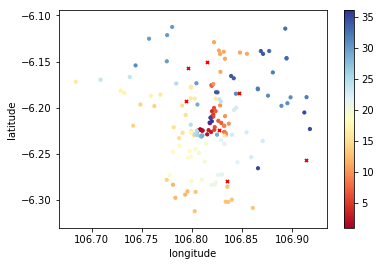

In [24]:
# Data visulization customer assigned to its kitchen

def visualize(data):
    x = data['long']
    y = data['lat']
    Cluster = data['kurir']
    cm = plt.cm.get_cmap('RdYlBu')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(x,y,c=Cluster, cmap=cm, s=10, label='customer')
    ax.scatter(kitchen['long'],kitchen['lat'], s=10, c='r', marker="x", label='second')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    plt.colorbar(scatter)

    fig.show()

visualize(customer1)

### Ketidaksempurnaan

-Grup customer dan kitchen belum optimum

-Waktu tempuh pengiriman hanya estimasi. Asumsi rata-rata 22kmpj 

http://www.viva.co.id/blog/entertainment/336836-kecepatan-rata-rata-motor-di-jakarta-22-kpj

In [25]:
customer1.drop(['degrees'],axis=1, inplace=True)
customer1.to_csv("result.csv", sep=',', encoding='utf-8')

In [26]:
customer1.head()

,customersName,long,lat,qtyOrdered,cluster,distance2cluster,kurir
0,86RWME7T,106.805662,-6.224949,1,0,8.298011,1
1,25NJXBFS,106.808248,-6.223407,5,0,8.097902,1
2,2K210EOB,106.810036,-6.224798,2,0,8.236993,1
3,51UBUO1K,106.810753,-6.224727,1,0,8.224544,2
4,569QB7TL,106.810202,-6.224817,1,0,8.237927,2
